In [6]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(10,10)})
color= sns.color_palette()
sns.set_palette(color)

*If you are viewing this via GitHub - aplogies for the alignment issues for the equations - this is an issue with github's notebook rendering which I have reported to them.*

### Generate some data

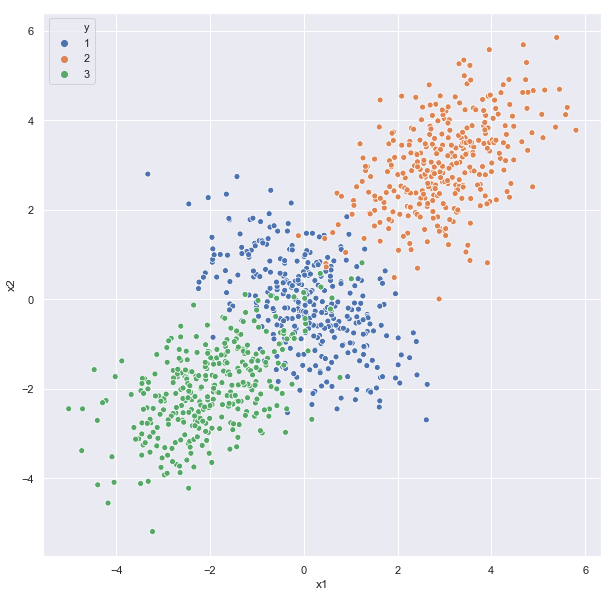

In [21]:
n = 333 # per group
g1_cov = np.array([[1,-0.5],[-0.5,1]])
g1 = np.random.multivariate_normal([0,0], g1_cov, 333)

g2_cov = np.array([[1,0.5],[0.5,1]])
g2 = np.random.multivariate_normal([3,3], g2_cov, 333)

g3_cov = np.array([[1,0.8],[0.8,1]])
g3 = np.random.multivariate_normal([-2,-2], g2_cov, 333)

X = np.vstack([g1, g2, g3])
y = np.hstack([np.repeat(1, 333), np.repeat(2, 333), np.repeat(3, 333)])

scatter_df = pd.concat([pd.DataFrame(X), pd.Series(y)], axis=1)
scatter_df.columns = ['x1', 'x2', 'y']
sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette=sns.color_palette(n_colors=3))

X = pd.DataFrame(X)
y = pd.Series(y)

### Model

We will assume the class conditional density of $X$ is given by the multivariate gaussian $f_k(x)$ where each class:
- Has a specific mean
- Has a specific covariance matrix

**NOTE** the distinction from [Linear Discriminant Analysis](https://github.com/coxy1989/mlsabbatical/blob/master/notebooks/algorithms/linear_discriminant_analysis.ipynb) where the classes are assumed to *share* a covariance matrix

One can [show](https://raw.githubusercontent.com/coxy1989/mlsabbatical/master/notebooks/statistical_learning/ch4_statistical_learning/Q3.jpeg) that the decision boundry is **not** linear when we permit each class to have its own covariance matrix.

With this amendment to the LDA model, the discriminant function is:

$\delta_k(x) = - \frac{log |\sum_k|}{2} - \frac{(x - \mu_k)^T \sum_k^{-1} (x - \mu_k)}{2} + log \pi_k$ 

In [9]:
def discriminant(Xs, sigma_c, mu_c, pi_c):
    # I'm computing the operands seperately for readability
    opr_1 = - (np.log(np.linalg.det(sigma_c)))/2
    opr_2 = np.diag((((Xs - mu_c) @ np.linalg.inv(sigma_c)) @ (Xs - mu_c).T)) / 2
    opr_3 = np.log(pi_c)
    return opr_1 - opr_2 + opr_3

def estimate_pi(X, class_indeces):
    'return numpy column vector'
    return np.array([X[idx_list].shape[0] / X.shape[0] for idx_list in class_indeces]).reshape(-1,1)

def estimate_mu(X, class_indeces):
    'return 2D numpy array'
    return np.array([X[idx_list].mean(axis=0).values for idx_list in class_indeces])

def estimate_sigma(Xc):
    'return 2D numpy array'
    # equivalent to np.cov(Xc, rowvar=False, ddof=0)
    return (((Xc - Xc.mean(axis=0)).T @ (Xc - Xc.mean(axis=0))) / (X.shape[0] - 1)).values


# fit the model
class_indeces = [y == v for v in y.unique()]
mu = estimate_mu(X, class_indeces)
pi = estimate_pi(X, class_indeces)
sigma_0 = estimate_sigma(X[class_indeces[0]])
sigma_1 = estimate_sigma(X[class_indeces[1]])
sigma_2 = estimate_sigma(X[class_indeces[2]])

### Decision Boundry

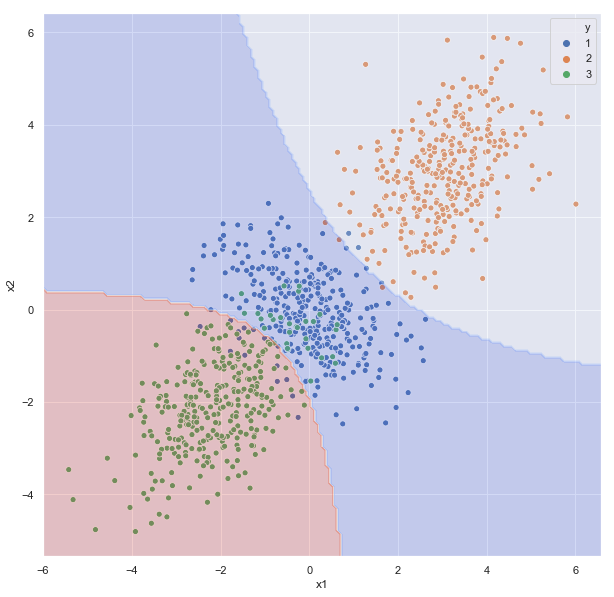

In [10]:
ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette=sns.color_palette(n_colors=3))
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
xx1 = np.linspace(x_min, x_max, 150)
xx2 = np.linspace(y_min, y_max, 150)
xx1, xx2 = np.meshgrid(xx1, xx2)
grid_X = np.vstack([xx1.ravel(), xx2.ravel()]).T


d1 = discriminant(grid_X, sigma_0, mu[0], pi[0]).reshape(-1, 1)
d2 = discriminant(grid_X, sigma_1, mu[1], pi[1]).reshape(-1, 1)
d3 = discriminant(grid_X, sigma_2, mu[2], pi[2]).reshape(-1, 1)


preds = np.argmax(np.hstack([d1,d2,d3]), axis=1) + 1
plt.contourf(xx1, xx2, preds.reshape(xx1.shape), alpha=0.25, cmap='coolwarm')

### Probability Contours

One can also plot the contours given by the probability for each class given by Bayes Rule

In [13]:
def fk(X, mu_k, sigma, p):
    denom = ((2 * np.pi) ** (p / 2)) * (np.linalg.det(sigma) ** 0.5)
    exp = - np.diag((X - mu_k.T) @ np.linalg.inv(sigma) @ ((X - mu_k.T).T)).reshape(-1,1)
    return (1 / denom) * np.exp(exp)

p1 = fk(grid_X, mu[0], sigma_0, 2) * pi[0] 
p2 = fk(grid_X, mu[1], sigma_1, 2) * pi[1] 
p3 = fk(grid_X, mu[2], sigma_2, 2) * pi[2]

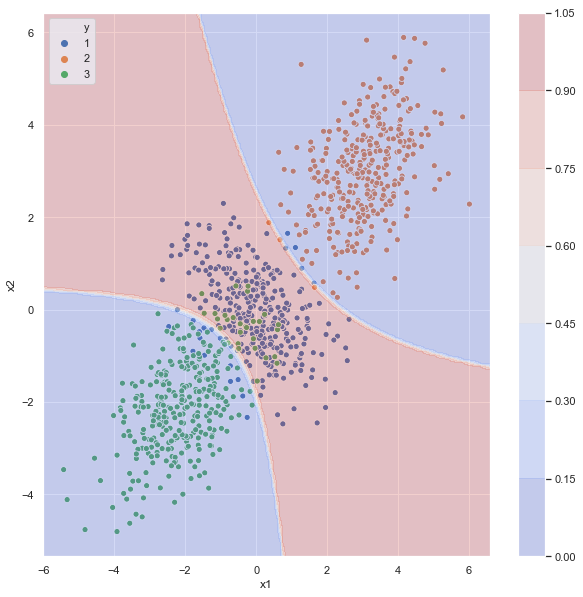

In [16]:
ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette=sns.color_palette(n_colors=3))
zz = (p1 / (p1 + p2 + p3)).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, alpha=0.25, cmap='coolwarm')
plt.colorbar()

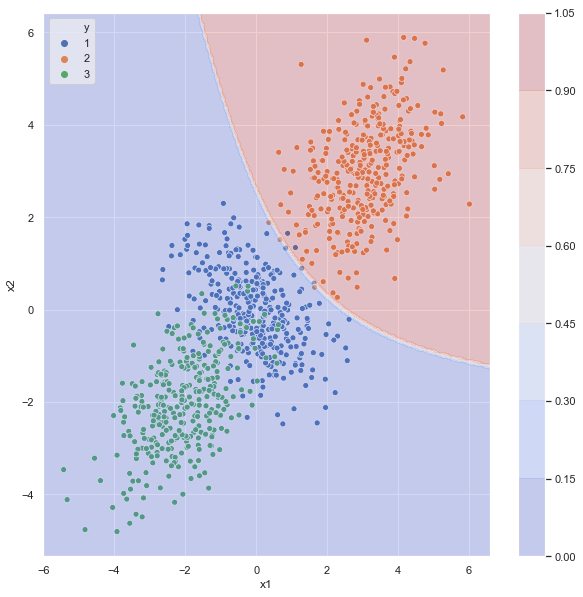

In [18]:
ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette=sns.color_palette(n_colors=3))
zz = (p2 / (p1 + p2 + p3)).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, alpha=0.25, cmap='coolwarm')
plt.colorbar()

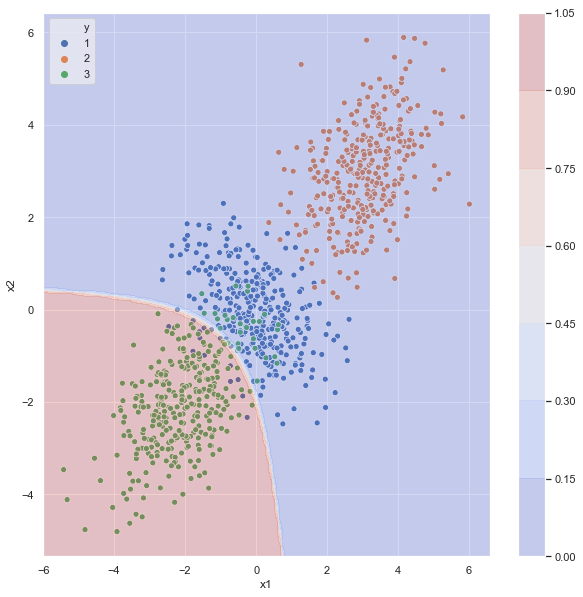

In [19]:
ax = sns.scatterplot(x='x1', y='x2', hue='y', data=scatter_df, palette=sns.color_palette(n_colors=3))
zz = (p3 / (p1 + p2 + p3)).reshape(xx1.shape)
plt.contourf(xx1, xx2, zz, alpha=0.25, cmap='coolwarm')
plt.colorbar()